In [1]:
pip install xml Pillow numpy scikit-image scikit-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xml (from versions: none)
ERROR: No matching distribution found for xml


In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
import os
import xml.etree.ElementTree as ET
from skimage import io, color, exposure, filters, feature
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage import img_as_ubyte

In [184]:
# Function to get bounding boxes from Annotations
def get_bounding_boxes(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []

    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))

    return bbox

In [185]:
# Function to crop and resize images
def crop_and_resize_images(image_folder, annotation_folder, output_folder):
    for class_folder in os.listdir(annotation_folder):
        annotation_path = os.path.join(annotation_folder, class_folder)

        # Check if the class folder contains any files
        class_files = os.listdir(annotation_path)
        if len(class_files) == 0:
            print(f"Warning: Class folder {class_folder} is empty.")
            continue

        # Iterate over annotation files in the class folder
        for annotation_file_name in class_files:
            annotation_file = os.path.join(annotation_path, annotation_file_name)

            # Construct corresponding image file path
            image_file_name = f"{os.path.splitext(annotation_file_name)[0]}.jpg"
            image_path = os.path.join(image_folder, class_folder, image_file_name)

            # Check if the image file exists
            if not os.path.exists(image_path):
                print(f"Warning: Image file for {annotation_file_name} does not exist. Expected: {image_path}")
                continue

            # Perform cropping and resizing using the provided code snippets
            bbox = get_bounding_boxes(annotation_file)
            im = Image.open(image_path)

            for j, (xmin, ymin, xmax, ymax) in enumerate(bbox):
                im2 = im.crop((xmin, ymin, xmax, ymax))
                im2 = im2.resize((128, 128), Image.ANTIALIAS)
                new_path = os.path.join(output_folder, class_folder, f"{os.path.splitext(image_file_name)[0]}-{j}.jpg")
                im2 = im2.convert('RGB')
                os.makedirs(os.path.dirname(new_path), exist_ok=True)
                im2.save(new_path)

In [207]:
def image_processing(image_folder):
    selected_images = []

    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                image_path = os.path.join(class_path, image_files[0])
                selected_images.append(image_path)

    for i, image_path in enumerate(selected_images):
        img = imread(image_path)

        # Check if the image is color (3 channels) or grayscale (1 channel)
        if img.ndim == 3 and img.shape[-1] == 3:
            gray_img = rgb2gray(img)  # Convert color images to grayscale
        else:
            gray_img = img  # Use grayscale image directly

        plt.subplot(2, 4, i % 8 + 1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')

    plt.show()

In [186]:
# Function to perform edge histogram and plot the results
def edge_histogram(output_folder):
    selected_images = []
    for class_folder in os.listdir(output_folder):
        class_path = os.path.join(output_folder, class_folder)

        # Print class folder path for debugging
        print(f"Class folder path: {class_path}")

        # Check if the class folder exists
        if not os.path.exists(class_path):
            print(f"Warning: Class folder {class_folder} does not exist.")
            continue

        # Check if the class folder contains any files
        class_files = os.listdir(class_path)
        if len(class_files) == 0:
            print(f"Warning: Class folder {class_folder} is empty.")
            continue

        # Select 1 image from each class
        image_path = os.path.join(class_path, class_files[0])
        selected_images.append(image_path)

        # Convert to grayscale
        im = io.imread(image_path)
        im_gray = color.rgb2gray(im)

        # Calculate angle for each pixel using arctan2
        gradient_y, gradient_x = np.gradient(im_gray)
        angle_sobel = np.arctan2(gradient_y, gradient_x)

        # Obtain histogram with 36 bins
        hist, bin_edges = exposure.histogram(angle_sobel, nbins=36)

        # Print information about the class folder
        print(f"Class folder: {class_folder}")
        print(f"Number of files: {len(class_files)}")

        # Plot images with corresponding edge histogram values
        plt.subplot(1, 2, 1)
        plt.imshow(im, cmap='gray')
        plt.title(f'Class {class_folder}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.plot(hist)
        plt.title('Edge Histogram')
        plt.xlabel('Bins')
        plt.ylabel('Pixel Count')

        plt.show()

In [187]:
def histogram_comparison(image_folder):
    # Pick 2 images from the same class and 1 image from another class
    class_folders = os.listdir(image_folder)

    # Check if there are at least three classes
    if len(class_folders) < 3:
        print("Warning: There are not enough classes for histogram comparison.")
        return

    class_paths = [os.path.join(image_folder, class_folder) for class_folder in class_folders[:3]]

    # Initialize vectors to store histogram representations
    histograms = []

    # Iterate over the first two classes
    for class_path in class_paths[:2]:
        image_path = os.path.join(class_path, os.listdir(class_path)[0])
        image = io.imread(image_path)
        gray_image = color.rgb2gray(image)
        histogram, _ = exposure.histogram(gray_image, nbins=256)
        histograms.append(histogram)

    # Iterate over the third class
    for image_path in os.listdir(class_paths[2]):
        full_image_path = os.path.join(class_paths[2], image_path)
        image = io.imread(full_image_path)
        gray_image = color.rgb2gray(image)
        histogram, _ = exposure.histogram(gray_image, nbins=256)

        # Compare histograms using different metrics
        euclidean_dist_same_class = euclidean_distances([histograms[0], histograms[1]])
        euclidean_dist_diff_class = euclidean_distances([histograms[0], histogram])

        manhattan_dist_same_class = manhattan_distances([histograms[0], histograms[1]])
        manhattan_dist_diff_class = manhattan_distances([histograms[0], histogram])

        cosine_dist_same_class = cosine_distances([histograms[0], histograms[1]])
        cosine_dist_diff_class = cosine_distances([histograms[0], histogram])

        print(f"Euclidean distance (same class): {euclidean_dist_same_class[0, 1]}")
        print(f"Euclidean distance (different class): {euclidean_dist_diff_class[0, 1]}\n")

        print(f"Manhattan distance (same class): {manhattan_dist_same_class[0, 1]}")
        print(f"Manhattan distance (different class): {manhattan_dist_diff_class[0, 1]}\n")

        print(f"Cosine distance (same class): {cosine_dist_same_class[0, 1]}")
        print(f"Cosine distance (different class): {cosine_dist_diff_class[0, 1]}\n")
        break  # Uncomment this line to process only one image from the third class


In [188]:
# Function to compute HOG descriptors and visualize
def hog_feature_descriptor(image_path):
    im = io.imread(image_path)
    im_gray = color.rgb2gray(im)

    # Compute HOG descriptors
    hog_features, hog_image = feature.hog(im_gray, visualize=True, block_norm='L2-Hys')

    # Visualize the image and HOG descriptors
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Descriptors')
    plt.axis('off')

    plt.show()

In [214]:
# Function to perform PCA dimensionality reduction and plot the results
def dimensionality_reduction(image_folder):
    selected_images = []

    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                image_path = os.path.join(class_path, image_files[0])
                selected_images.append(image_path)

    for i, image_path in enumerate(selected_images):
        img = imread(image_path)

        # Convert to grayscale
        gray_img = rgb2gray(img) if img.ndim == 3 and img.shape[-1] == 3 else img

        # Apply Local Binary Pattern (LBP)
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')

        # Normalize the LBP image
        lbp = img_as_ubyte(lbp / lbp.max())

        plt.subplot(2, 4, i % 8 + 1)
        plt.imshow(lbp, cmap='gray')
        plt.axis('off')

    plt.show()

In [196]:
image_folder = '/content/drive/MyDrive/images'
annotation_folder = '/content/drive/MyDrive/Annotations'
output_folder = '/content/drive/MyDrive/output folder'


In [197]:
# Task (a): Crop and Resize Images
crop_and_resize_images(image_folder, annotation_folder, output_folder)


<ipython-input-185-3e0e7c0c117a>:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im2 = im2.resize((128, 128), Image.ANTIALIAS)


In [198]:
# Function to print contents of class folders
def print_class_folder_contents(output_folder):
    for class_folder in os.listdir(output_folder):
        class_path = os.path.join(output_folder, class_folder)

        # Print class folder path
        print(f"Class folder path: {class_path}")

        # Check if the class folder exists
        if not os.path.exists(class_path):
            print(f"Warning: Class folder {class_folder} does not exist.")
            continue

        # List and print the contents of the class folder
        class_contents = os.listdir(class_path)
        print(f"Contents of {class_folder} class folder: {class_contents}")

In [199]:
output_folder = '/content/drive/MyDrive/output folder'

# Print contents of class folders
print_class_folder_contents(output_folder)

Class folder path: /content/drive/MyDrive/output folder/n02093428-American_Staffordshire_terrier
Contents of n02093428-American_Staffordshire_terrier class folder: ['n02093428_1162-0.jpg', 'n02093428_15280-0.jpg', 'n02093428_16660-0.jpg', 'n02093428_10328-0.jpg', 'n02093428_1439-0.jpg', 'n02093428_15747-0.jpg', 'n02093428_1278-0.jpg', 'n02093428_15784-0.jpg', 'n02093428_11793-0.jpg', 'n02093428_14706-0.jpg', 'n02093428_1108-0.jpg', 'n02093428_10807-0.jpg', 'n02093428_1070-0.jpg', 'n02093428_111-0.jpg', 'n02093428_12462-0.jpg', 'n02093428_12016-0.jpg', 'n02093428_14471-0.jpg', 'n02093428_11598-0.jpg', 'n02093428_10929-0.jpg', 'n02093428_1746-0.jpg', 'n02093428_14252-0.jpg', 'n02093428_1641-0.jpg', 'n02093428_14990-0.jpg', 'n02093428_14550-0.jpg', 'n02093428_12791-0.jpg', 'n02093428_10381-0.jpg', 'n02093428_17280-0.jpg', 'n02093428_14485-0.jpg', 'n02093428_11160-0.jpg', 'n02093428_16245-0.jpg', 'n02093428_13615-0.jpg', 'n02093428_16887-0.jpg', 'n02093428_1351-0.jpg', 'n02093428_15872-0.j

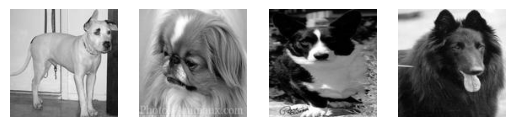

In [208]:
# Task (b) Image Processing
image_processing(output_folder)

Class folder path: /content/drive/MyDrive/output folder/n02093428-American_Staffordshire_terrier
Class folder: n02093428-American_Staffordshire_terrier
Number of files: 172


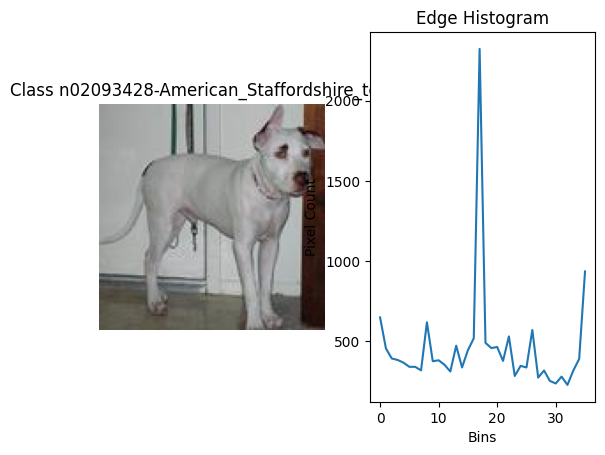

Class folder path: /content/drive/MyDrive/output folder/n02085782-Japanese_spaniel
Class folder: n02085782-Japanese_spaniel
Number of files: 202


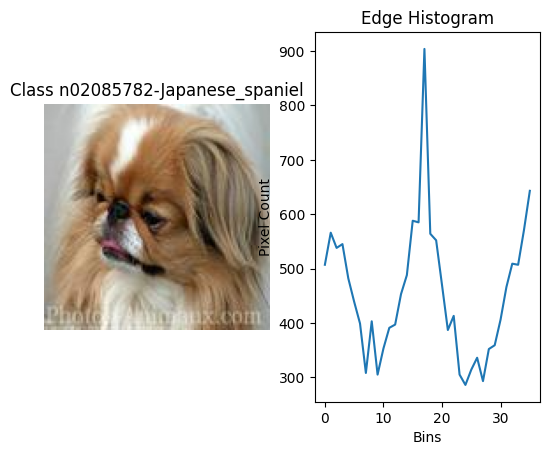

Class folder path: /content/drive/MyDrive/output folder/n02113186-Cardigan
Class folder: n02113186-Cardigan
Number of files: 170


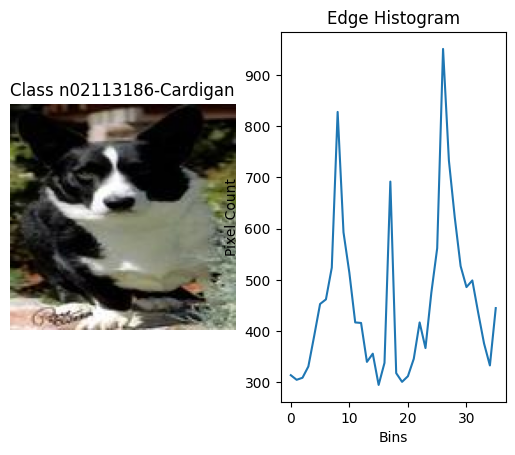

Class folder path: /content/drive/MyDrive/output folder/n02105056-groenendael
Class folder: n02105056-groenendael
Number of files: 152


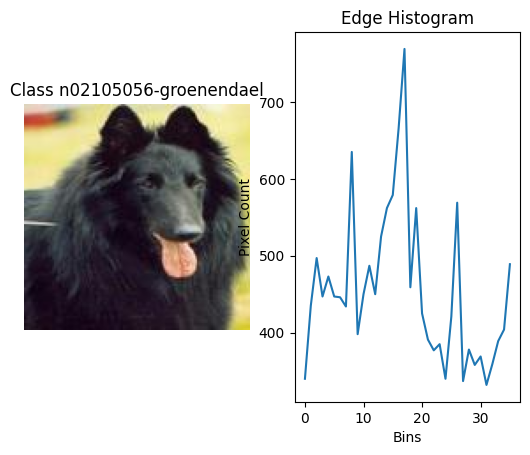

In [209]:
# Task (c) Edge Histogram
edge_histogram(output_folder)

In [210]:
# Task (d) Histogram Comparison
histogram_comparison(image_folder)

Euclidean distance (same class): 15045.626075374863
Euclidean distance (different class): 14467.601874533319

Manhattan distance (same class): 113674.0
Manhattan distance (different class): 126266.0

Cosine distance (same class): 0.5162432082865698
Cosine distance (different class): 0.43447363886774804



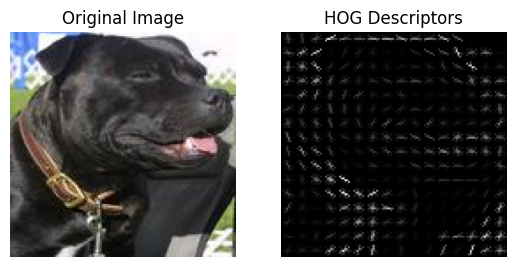

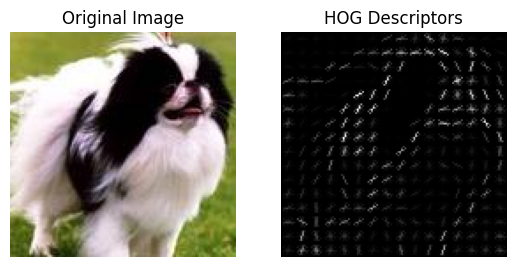

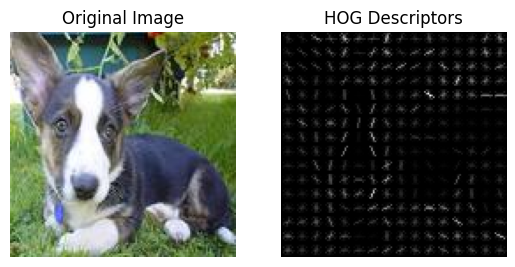

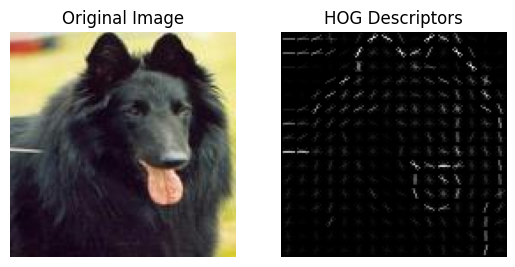

In [217]:
# Task (e) Histogram of Oriented Gradient (HOG) feature descriptor
# Select one image for HOG feature descriptor visualization
hog_feature_descriptor(os.path.join(output_folder, 'n02093428-American_Staffordshire_terrier', 'n02093428_10328-0.jpg'))
hog_feature_descriptor(os.path.join(output_folder, 'n02085782-Japanese_spaniel', 'n02085782_1039-0.jpg'))
hog_feature_descriptor(os.path.join(output_folder, 'n02113186-Cardigan', 'n02113186_1030-0.jpg'))
hog_feature_descriptor(os.path.join(output_folder, 'n02105056-groenendael', 'n02105056_1061-0.jpg'))



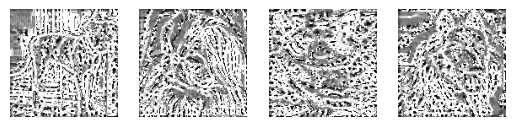

In [215]:
# Task (f) Dimensionality Reduction (PCA)
dimensionality_reduction(output_folder)